<a href="https://colab.research.google.com/github/Portilloronny6/Make-Money-MLCourse/blob/master/Homework_2_Ronny_Portillo_Predicting_Stock_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import datetime 
import pandas_datareader.data as web
from sklearn import linear_model
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import style

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv1D, LSTM, Dense
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.losses import Huber
from keras.optimizers import SGD

style.use('ggplot')

Using TensorFlow backend.


In [2]:
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2019, 9, 3)
df = web.DataReader('TSLA', 'yahoo', start, end)
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-06-29,25.00,17.540001,19.000000,23.889999,18766300,23.889999
2010-06-30,30.42,23.299999,25.790001,23.830000,17187100,23.830000
2010-07-01,25.92,20.270000,25.000000,21.959999,8218800,21.959999
2010-07-02,23.10,18.709999,23.000000,19.200001,5139800,19.200001
2010-07-06,20.00,15.830000,20.000000,16.110001,6866900,16.110001


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2311 entries, 2010-06-29 to 2019-09-03
Data columns (total 6 columns):
High         2311 non-null float64
Low          2311 non-null float64
Open         2311 non-null float64
Close        2311 non-null float64
Volume       2311 non-null int64
Adj Close    2311 non-null float64
dtypes: float64(5), int64(1)
memory usage: 126.4 KB


Text(0, 0.5, 'Adj Close ($)')

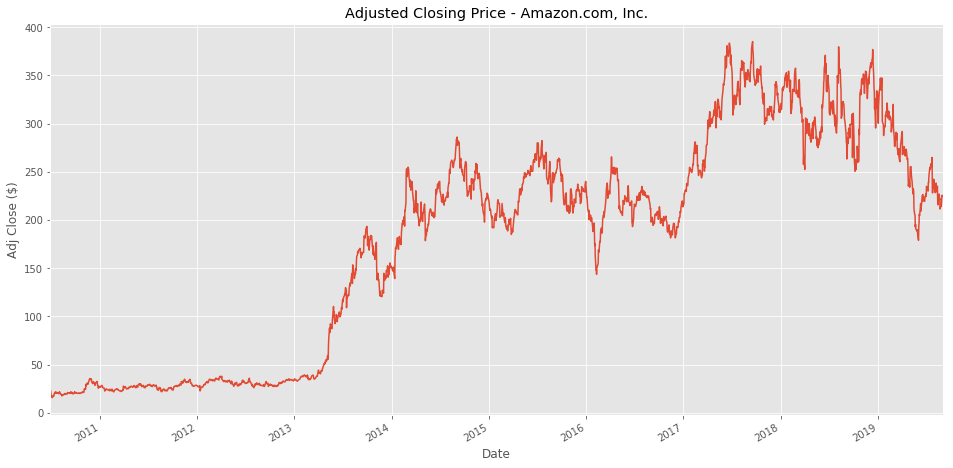

In [4]:
df['Adj Close'].plot(figsize = (16,8), title = 'Adjusted Closing Price - Amazon.com, Inc.')
plt.ylabel('Adj Close ($)')

In [0]:
windowsSize = 32

numSamples = len(df) - windowsSize

indices = np.arange(numSamples).astype(np.int)[:, None] + np.arange(windowsSize + 1).astype(np.int) #Add one to make reference to the column to predict

In [0]:
#For each point in indices, I'm going to create a new variable called *data* that contains a value from my dataframe df associated to the indices's point.
data = df['Adj Close'].values[indices]

In [0]:
X = data[:,:-1] # Each row represents 32 days in the past
Y = data[:,-1] # Each output value represents the 33rd day

In [0]:
splitFraction = 0.8
indSplit = int(splitFraction * numSamples)
xTrain = X[:indSplit]
yTrain = Y[:indSplit]
xTest = X[indSplit:]
yTest = Y[indSplit:]

In [0]:
def metricas(model, real, prediction):
  
  regression_metrics = {'Root Mean Squared Error' : metrics.mean_squared_error(real, prediction)**0.5, 
                       'Mean Absolute Error' : metrics.mean_absolute_error(real, prediction),
                       'R^2' : metrics.r2_score(real, prediction),
                       'Explained Variance' : metrics.explained_variance_score(real, prediction),
                      }

  df_metrics = pd.DataFrame.from_dict(regression_metrics, orient= 'index' )
  df_metrics.columns = [model]

  return df_metrics

# **Lineal model**

In [0]:
#Training
linealModel = linear_model.LinearRegression()
linealModel.fit(xTrain, yTrain)

#Predicting
y_pred_train_lineal = linealModel.predict(xTrain)
y_pred_lineal = linealModel.predict(xTest)

Text(0, 0.5, 'Adj Close ($)')

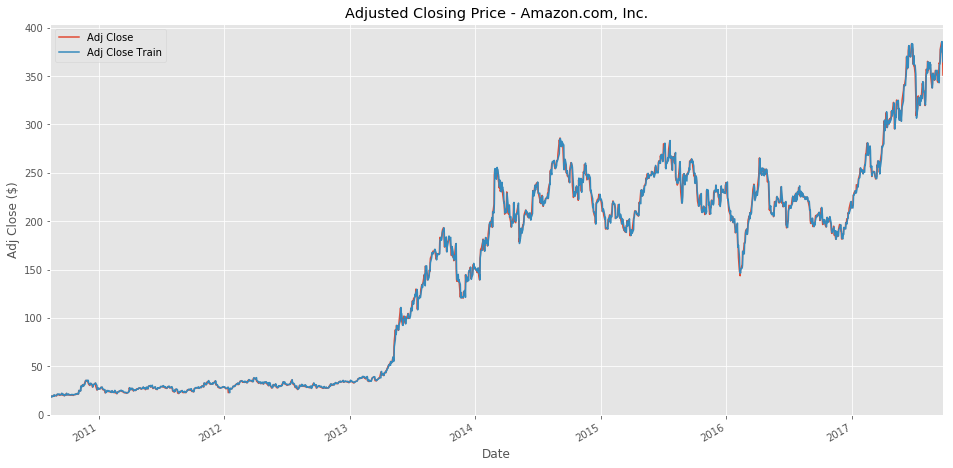

In [11]:
# Plot what it looks like for the training data
df_lineal = df.copy()
df_lineal.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis = 1, inplace = True)
df_lineal = df_lineal.iloc[windowsSize:indSplit] # Past 32 days we don't know yet
df_lineal['Adj Close Train'] = y_pred_train_lineal[:-windowsSize]
df_lineal.plot(label='TSLA', figsize=(16,8), title='Adjusted Closing Price - Amazon.com, Inc.', grid=True)
plt.ylabel('Adj Close ($)')

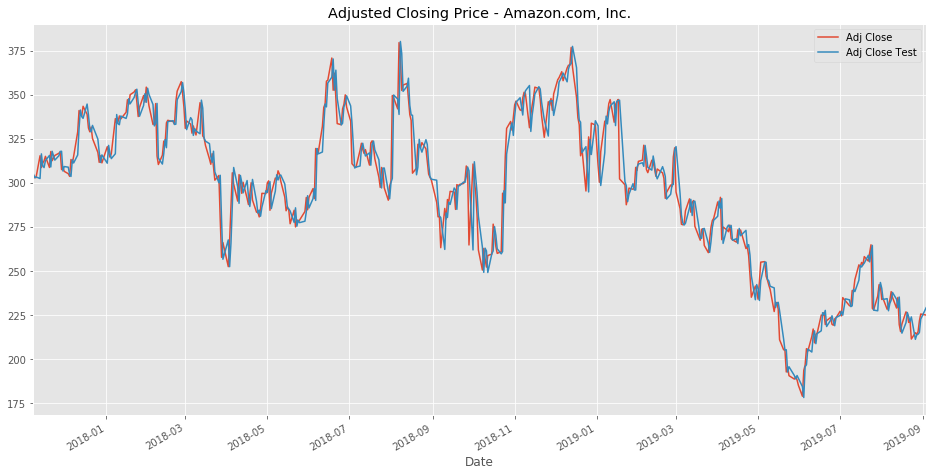

In [12]:
df_lineal = df.copy()
df_lineal.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis = 1, inplace = True)
df_lineal = df_lineal.iloc[indSplit + windowsSize:]
df_lineal['Adj Close Test'] = y_pred_lineal
df_lineal.plot(label='TSLA', figsize=(16,8), title='Adjusted Closing Price - Amazon.com, Inc.', grid=True)

In [13]:
print(' R^2 training: {0:.2f} \n\n R^2 test: {1:.2f}'.format(metrics.r2_score(yTrain, y_pred_train_lineal), 
                                                             metrics.r2_score(yTest, y_pred_lineal)))

linreg_metrics = metricas('Lineal Regression', yTest, y_pred_lineal)
linreg_metrics

 R^2 training: 1.00 

 R^2 test: 0.95


,Lineal Regression
Root Mean Squared Error,10.039958
Mean Absolute Error,7.001917
R^2,0.946560
Explained Variance,0.946589


# **Lasso Regression**

In [14]:
lasso_model = linear_model.Lasso(alpha = 0.01)
lasso_model.fit(xTrain, yTrain)

# Predictions 
y_pred_train_lasso = lasso_model.predict(xTrain)
y_pred_lasso = lasso_model.predict(xTest)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24114.724606823595, tolerance: 2064.6429990202305
  positive)


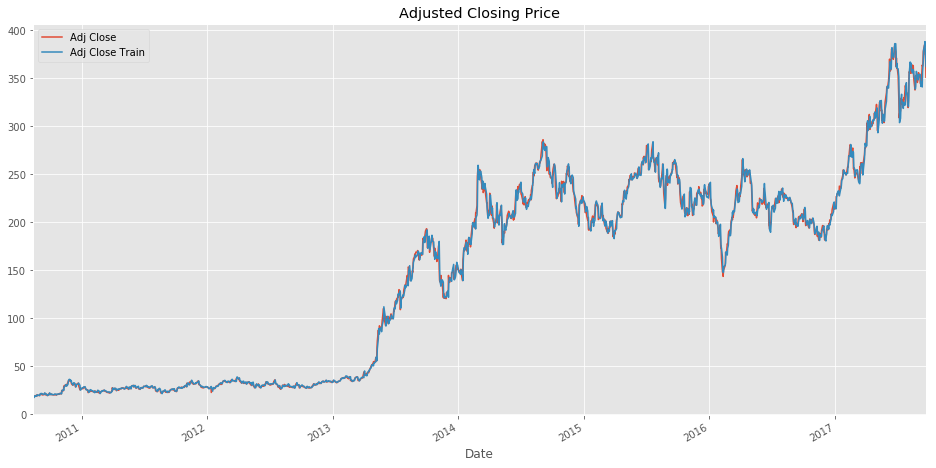

In [15]:
df_lasso = df.copy()
df_lasso.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis = 1, inplace = True)
df_lasso = df_lasso.iloc[windowsSize:indSplit]
df_lasso['Adj Close Train'] = y_pred_train_lasso[:-windowsSize]
df_lasso.plot(label='TSLA', figsize = (16,8), title = 'Adjusted Closing Price', grid = True)

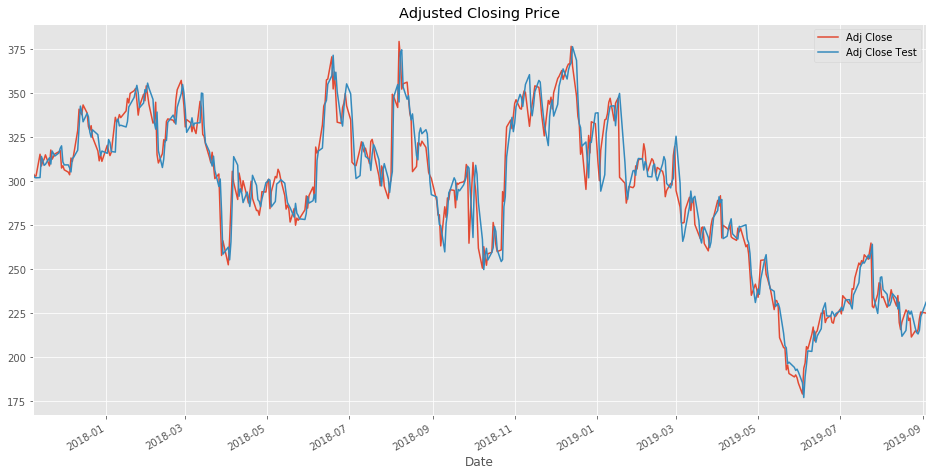

In [16]:
df_lasso = df.copy()
df_lasso.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis = 1, inplace = True)
df_lasso = df_lasso.iloc[indSplit + windowsSize:]
df_lasso['Adj Close Test'] = y_pred_lasso
df_lasso.plot(label='TSLA', figsize = (16,8), title = 'Adjusted Closing Price', grid = True)

In [17]:
print(' R^2 training: {0:.2f} \n\n R^2 test: {1:.2f}'.format(metrics.r2_score(yTrain, y_pred_train_lasso), 
                                                             metrics.r2_score(yTest, y_pred_lasso)))

lasso_metrics = metricas('Lasso Regression', yTest, y_pred_lasso)
lasso_metrics

 R^2 training: 1.00 

 R^2 test: 0.94


,Lasso Regression
Root Mean Squared Error,10.718038
Mean Absolute Error,7.692186
R^2,0.939098
Explained Variance,0.939153


# **Neural Networks**

In [18]:
keras_model = Sequential ([
    Conv1D(filters = 128, kernel_size = 5, input_shape = (windowsSize, 1), strides = 1, padding = "causal", activation = "tanh"),
    Conv1D(filters = 128, kernel_size = 5, strides = 1, padding = "causal", activation = "tanh"),
    LSTM(128, return_sequences = True),
    LSTM(128),
    Dense(64, activation = "tanh"),
    Dense(64, activation = "tanh"),
    Dense(1)    
])

keras_model.summary()

W0905 00:32:07.169878 139659736770432 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0905 00:32:07.193230 139659736770432 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0905 00:32:07.195968 139659736770432 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 32, 128)           768       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 32, 128)           82048     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32, 128)           131584    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [19]:
lr_schedule = LearningRateScheduler(lambda epoch: 1e-8 * 10 ** (epoch / 20))
optimizer = SGD(lr = 1e-8, momentum = 0.9)
keras_model.compile(loss= Huber(),
                   optimizer = optimizer,
                   metrics = ["mae"])

scaler = MinMaxScaler(feature_range = (-1, 1))
data_transform = scaler.fit_transform(df['Adj Close'].values[:,None])
data_transform = data_transform[indices]
X2 = data_transform[:, :-1]
y2 = data_transform[:, -1]
X_train_reshape = X2[:indSplit]
y_train_reshape = y2[:indSplit]
X_test_reshape = X2[indSplit:]
y_test_reshape = y2[indSplit:]

W0905 00:32:07.689288 139659736770432 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [20]:
history = keras_model.fit(X_train_reshape, y_train_reshape, batch_size = 256, epochs = 250, callbacks = [lr_schedule], validation_data = (X_test_reshape, y_test_reshape))

W0905 00:32:07.849076 139659736770432 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0905 00:32:09.015247 139659736770432 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1033: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0905 00:32:09.069143 139659736770432 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1020: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 1823 samples, validate on 456 samples
Epoch 1/250
1823/1823 [==============================] - 5s 3ms/step - loss: 0.1874 - mean_absolute_error: 0.4957 - val_loss: 0.1540 - val_mean_absolute_error: 0.5063
Epoch 2/250
1823/1823 [==============================] - 1s 452us/step - loss: 0.1874 - mean_absolute_error: 0.4957 - val_loss: 0.1540 - val_mean_absolute_error: 0.5063
Epoch 3/250
1823/1823 [==============================] - 1s 450us/step - loss: 0.1874 - mean_absolute_error: 0.4957 - val_loss: 0.1540 - val_mean_absolute_error: 0.5063
Epoch 4/250
1823/1823 [==============================] - 1s 446us/step - loss: 0.1874 - mean_absolute_error: 0.4957 - val_loss: 0.1540 - val_mean_absolute_error: 0.5063
Epoch 5/250
1823/1823 [==============================] - 1s 452us/step - loss: 0.1874 - mean_absolute_error: 0.4957 - val_loss: 0.1540 - val_mean_absolute_error: 0.5064
Epoch 6/250
1823/1823 [==============================] - 1s 448us/step - loss: 0.1874 - mean_absolute_error: 0

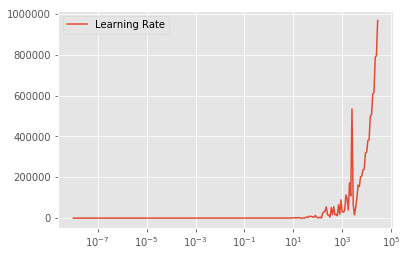

In [21]:
plt.semilogx(history.history['lr'], history.history['val_loss'])
plt.legend(['Learning Rate', 'Validation Loss'])

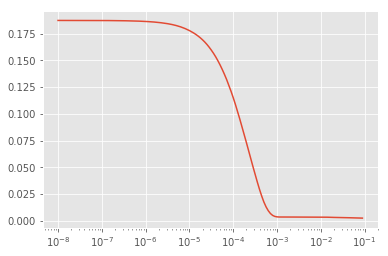

In [22]:
plt.semilogx(history.history['lr'][:140], history.history['loss'][:140])

In [23]:
keras_model = Sequential ([
    Conv1D(filters = 128, kernel_size = 5, input_shape = (windowsSize, 1), strides = 1, padding = "causal", activation = "tanh"),
    Conv1D(filters = 128, kernel_size = 5, strides = 1, padding = "causal", activation = "tanh"),
    LSTM(128, return_sequences = True),
    LSTM(128),
    Dense(64, activation = "tanh"),
    Dense(1)    
])

optimizer = SGD(lr = 0.1, momentum = 0.9)
keras_model.compile(loss= Huber(),
                   optimizer = optimizer,
                   metrics = ["mae"])

history = keras_model.fit(X_train_reshape, y_train_reshape, batch_size = 256, epochs = 250, validation_data = (X_test_reshape, y_test_reshape))

Train on 1823 samples, validate on 456 samples
Epoch 1/250
1823/1823 [==============================] - 2s 1ms/step - loss: 0.0795 - mean_absolute_error: 0.3348 - val_loss: 0.0157 - val_mean_absolute_error: 0.1403
Epoch 2/250
1823/1823 [==============================] - 1s 441us/step - loss: 0.0224 - mean_absolute_error: 0.1804 - val_loss: 0.0086 - val_mean_absolute_error: 0.1032
Epoch 3/250
1823/1823 [==============================] - 1s 426us/step - loss: 0.0124 - mean_absolute_error: 0.1190 - val_loss: 0.0232 - val_mean_absolute_error: 0.1860
Epoch 4/250
1823/1823 [==============================] - 1s 427us/step - loss: 0.0070 - mean_absolute_error: 0.0930 - val_loss: 0.0078 - val_mean_absolute_error: 0.0993
Epoch 5/250
1823/1823 [==============================] - 1s 435us/step - loss: 0.0046 - mean_absolute_error: 0.0753 - val_loss: 0.0079 - val_mean_absolute_error: 0.0985
Epoch 6/250
1823/1823 [==============================] - 1s 436us/step - loss: 0.0039 - mean_absolute_error: 0

In [0]:
y_pred_train_keras = scaler.inverse_transform(keras_model.predict(X_train_reshape, batch_size=256))
y_pred_keras = scaler.inverse_transform(keras_model.predict(X_test_reshape, batch_size=256))

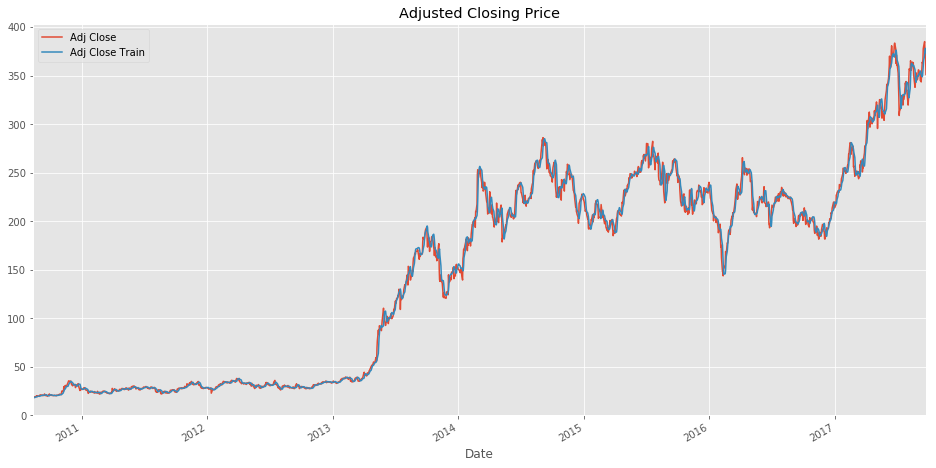

In [25]:
# Plot what it looks like for the training data
df_keras = df.copy()
df_keras.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_keras = df_keras.iloc[windowsSize:indSplit] # Past 32 days we don't know yet
df_keras['Adj Close Train'] = y_pred_train_keras[:-windowsSize]
df_keras.plot(label='TSLA', figsize=(16,8), title='Adjusted Closing Price', grid=True)


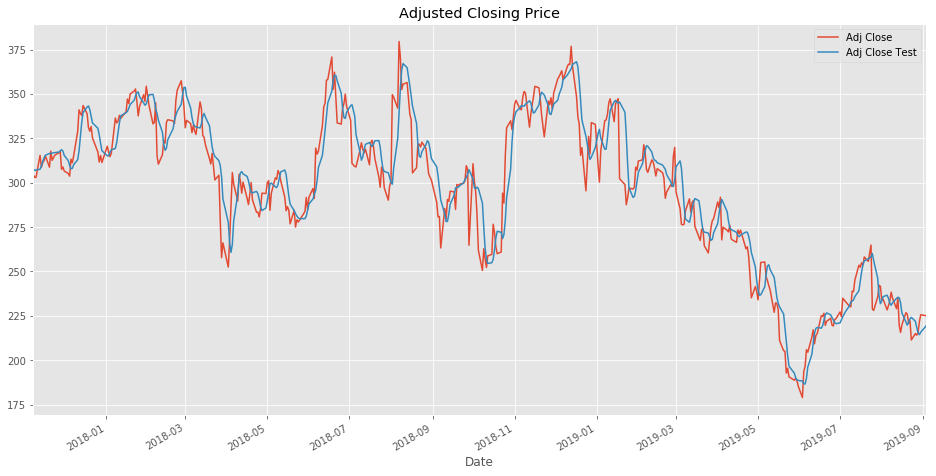

In [26]:
# Same for the test
df_keras = df.copy()
df_keras.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_keras = df_keras.iloc[indSplit+windowsSize:] # Past 32 days we don't know yet
df_keras['Adj Close Test'] = y_pred_keras
df_keras.plot(label='TSLA', figsize=(16,8), title='Adjusted Closing Price', grid=True)

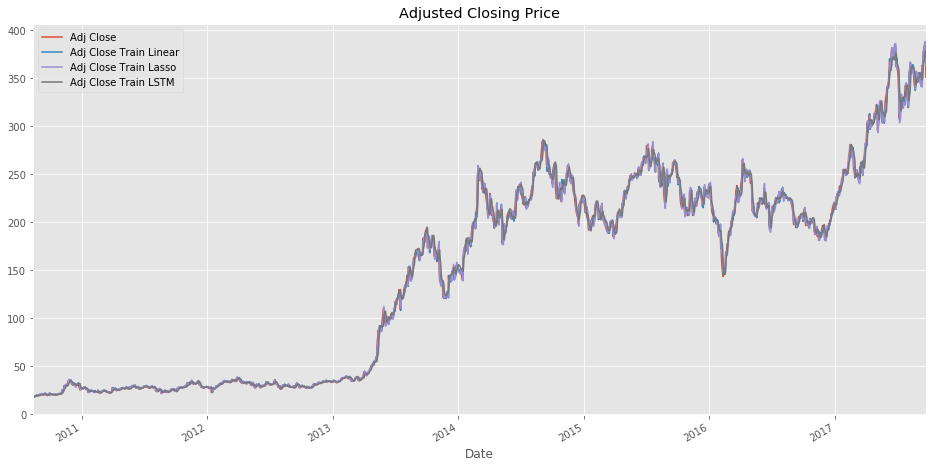

In [27]:
df_train = df.copy()
df_train.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_train = df_train.iloc[windowsSize:indSplit] # Past 32 days we don't know yet

# Add in all of our methods
df_train['Adj Close Train Linear'] = y_pred_train_lineal[:-windowsSize]
df_train['Adj Close Train Lasso'] = y_pred_train_lasso[:-windowsSize]
df_train['Adj Close Train LSTM'] = y_pred_train_keras[:-windowsSize]

# Plot the data now
df_train.plot(label='TSLA', figsize=(16,8), title='Adjusted Closing Price', grid=True)

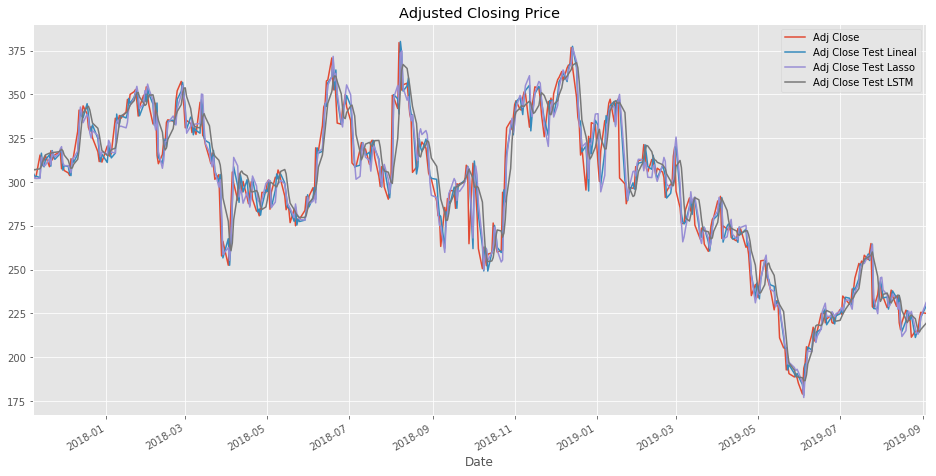

In [28]:
df_test = df.copy()
df_test.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_test = df_test.iloc[indSplit+windowsSize:] # Past 32 days we don't know yet
# Add in all of our methods
df_test['Adj Close Test Lineal'] = y_pred_lineal
df_test['Adj Close Test Lasso'] = y_pred_lasso
df_test['Adj Close Test LSTM'] = y_pred_keras
# Plot the data now
df_test.plot(label='TSLA', figsize=(16,8), title='Adjusted Closing Price', grid=True)

In [0]:
num_days = 10 # Let's try and forecase the next 10 days or two years

# Get the last window_size (32) days
data_seed = df['Adj Close'].values[-windowsSize:][None]
# Get the normalized data as well for the neural network
data_seed_norm = scaler.transform(data_seed)
input_values = {"linear": data_seed, "lasso": data_seed, "keras": data_seed_norm.copy()}
values = {"linear": [], "lasso": [], "keras": []}
for i in range(num_days): # For each day...
    # Predict the next price given the previous N prices
    values["linear"].append(linealModel.predict(input_values["linear"])[0])
    values["lasso"].append(lasso_model.predict(input_values["lasso"])[0])
    values["keras"].append(keras_model.predict(input_values["keras"][...,None])[0][0])

    # Dump the oldest price and put the newest price at the end
    for v in input_values:
        val = input_values[v]
        val = np.insert(val, -1, values[v][-1], axis=1)
        val = np.delete(val, 0, axis=1)
        input_values[v] = val.copy()

# Convert all to NumPy arrays
for v in input_values:
    values[v] = np.array(values[v])

# Unnormalize prices from NN approach
values["keras"] = scaler.inverse_transform(values["keras"][None])[0]

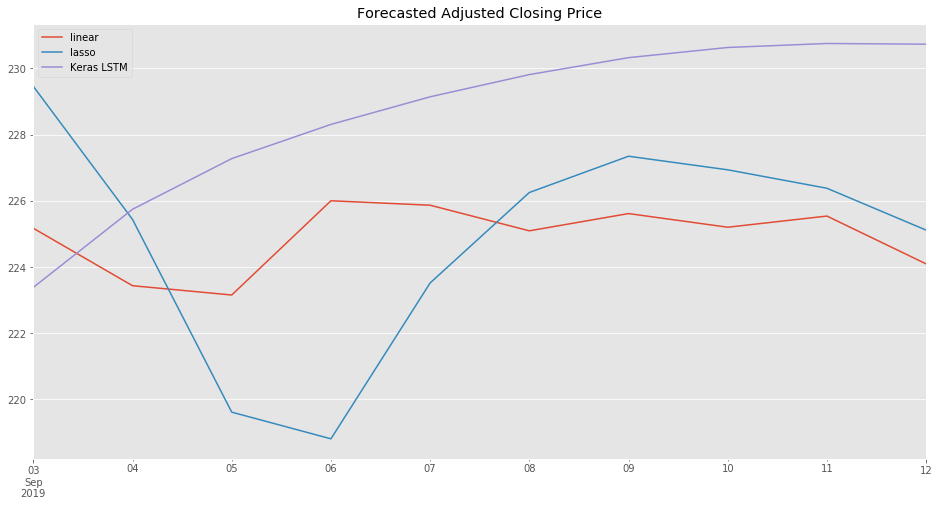

In [30]:
from datetime import timedelta, datetime
last_date = datetime.strptime(df.index[-1].strftime('%Y-%m-%d'), '%Y-%m-%d')
df_forecast = pd.DataFrame()
df_forecast["linear"] = values["linear"]
df_forecast["lasso"] = values["lasso"]
df_forecast["Keras LSTM"] = values["keras"]
df_forecast.index = pd.date_range(start=last_date, periods=num_days)
df_forecast.plot(label='TSLA', figsize=(16,8), title='Forecasted Adjusted Closing Price', grid=True)